In [6]:
from quspin.basis import spin_basis_general # Hilbert space spin basis
import numpy as np
import math
from numpy import linalg as LA
import matplotlib.pyplot as plt
from quspin.basis import spin_basis_1d 
from scipy.linalg import expm
np.random.seed(0)
L=16
basis=spin_basis_general(L,)
Ns = basis.Ns 
antiferomagnets=np.zeros(basis.Ns)
Name=''
for j in range(L):
      if j%2==0:
       Name+="0"
      else:
       Name+='1'
array_ind_s=basis.index(basis.state_to_int(Name))
antiferomagnets[array_ind_s]=1.0
print(antiferomagnets)

[0. 0. 0. ... 0. 0. 0.]


In [7]:
import numpy as np

data_type=np.complex128

S_z = np.diag([1.,-1.]).astype(data_type)
S_x =np.array([[0.,1.],[1.,0.]],dtype=data_type)
S_y=np.array([[0.,complex(0,-1.)],[complex(0,1.),0.]],dtype=data_type) #Pauli Matrices


def Matrix_product_states(Fs,L,chi):
  v,vi,Gamma=[],[],[]
  k=ka(L,cap=chi)
  vi.append(np.array([1.]))
  v.append(np.array([1.]))
 # Main loop

  for j in range(L):
    Fs=Fs.reshape(2*k[j],-1)
    #S,vy,D=LA.svd(Fs,full_matrices=False)
    S,vy,D=truncate(j,Fs,k)
    #Creating V
    v.append(vy)
    vi.append(np.divide(1.0, vy, out=np.zeros_like(vy), where=np.abs(vy)>=1E-14))
    #Y array
    Fs=np.einsum('a,aib->aib',vy,D)
    #Creating X
    #if j!=L-1:
    Gamma.append(np.einsum("a,aib->aib",vi[j],S))
 
  return Gamma,v
def ka(L,exact=False,cap=32):
   if exact:
     k=np.zeros(L+1,dtype=int)
     for j in range(L+1):
      if j<L/2:
       k[j]=int(pow(2,j))
      else:
       k[j]=int(pow(2,L-j))
     return k
   else:
     k=np.zeros(L+1,dtype=int)
     for j in range(L+1):
      if j<L/2:
       k[j]=min(int(pow(2,j)),cap)
      else:
       k[j]=min(int(pow(2,L-j)),cap)
     return k
def chi_trunc(chi,Fs,d=2):
  S,V,D = LA.svd(Fs,full_matrices=False)
    
  lam = V[:chi]/LA.norm(V[:chi])
  
  
  A=S[:,:chi].reshape(chi,d,chi)
  B=D[:chi].reshape(chi,d,chi)
  
  return A,lam,B
def truncate(j,Fs,k,d=2):
    
    S,V,D=LA.svd(Fs,full_matrices=False)
    
    lam= V[:k[j+1]]/LA.norm(V[:k[j+1]])
   
    A=S[:,:k[j+1]].reshape(k[j],d,k[j+1])
    if j!=L-1:
     B=D[:k[j+1]].reshape(k[j+1],d,-1)
    else:
      B=np.array([[[1.]]])
    return A,lam,B


In [8]:
def iDMRG(L_env,W,R_env,A,B,Ener,Ener1,lam,n):
    for i in range(n):
     #print(i)
     Ha=np.einsum("abc,bdij->adijc",L_env,W)
     Haa=np.einsum("adijc,dekl->aekl ijc",Ha,W)
     H=np.einsum("aekl ijc,feg->aikf cjlg",Haa,R_env).reshape((chi*chi*d**2,chi*chi*d**2))
    
     
     As = LinearOperator((chi*chi*d**2,chi*chi*d**2), matvec=H_mult,dtype=data_type)
     
     Theta = np.einsum("aib,b,bjc->aijc",A,lam[1],B).reshape(chi*chi*d**2)
     if __name__ == "__main__":
      w, v = eigsh(As,k=1,v0=Theta,which="SA")

     Theta_p = v[:,0].reshape(chi*d,chi*d)
     Theta_p/=LA.norm(Theta_p)

     A,lamb,B=chi_trunc(chi,Theta_p,d=d)
    
     lam[1]=lamb
    
     Le=np.einsum("amb,aic->mbic",L_env,A)   
     Le1=np.einsum("mbic,mlij->bclj",Le,W)   
     L_env=np.einsum("bclj,bjd->cld",Le1,np.conj(A))

     Re=np.einsum("amb,cia->mbci",R_env,B)
     Re1=np.einsum("mbci,lmij->bclj",Re,W)
     R_env=np.einsum("bclj,djb->cld",Re1,np.conj(B))
    
     Uppera = np.einsum("aib,b->aib",A,lam[1])
     Upper = np.einsum("aib,bdk->aidk",Uppera,B)
    
     Enera=np.einsum("amc,aikb->ikbmc",L_env,Upper)
     Eneraa=np.einsum("ikbmc,mlij->ljkbc",Enera,W)
     Eneraaa=np.einsum("ljkbc,ldkv->jdbvc",Eneraa,W)
     Eneraaaa=np.einsum("jdbvc,cjvh->dbh",Eneraaa,np.conj(Upper))
     Ener[i]=np.einsum("dbh,bdh->",Eneraaaa,R_env)
     Ener1[i]=Ener[i]/2/(i+1)
    

In [9]:
def H_mult(v):
  return np.matmul(H,v)

In [27]:
from numpy.random import random as rnd
from numpy import linalg as LA
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import eigsh
import cProfile
import pstats
np.random.seed(121)
chi = 20                   # Dimension for bond index
chi_DMRG = 3                  # Dimension for bond DMRG index
L=18                    
J_zz = 0.2
hx = 0.13
#J_xx = 0.46
d = 2                         # Dimension for physical index  

Fs=np.array([rnd()+rnd()*1j for d in range(2**L)]).astype(data_type)
Fs=(Fs/LA.norm(Fs))
n=100                       # Number of sweeps

W = np.zeros((chi_DMRG,chi_DMRG,d,d),dtype=data_type)
W[0,0] = np.array(np.eye(2),dtype=data_type)
W[0,1] = S_z
#W[0,2] = S_x
W[0,2] = hx*S_x
W[1,2] = J_zz*S_z
#W[2,3] = J_xx*S_x
W[2,2] = np.array(np.eye(2),dtype=data_type) # MPO rep

v_L,v_R=np.zeros(chi_DMRG,dtype=data_type),np.zeros(chi_DMRG,dtype=data_type)
v_L[0],v_R[-1]=1.,1. 

L_env,R_env=np.zeros((chi,chi_DMRG,chi),dtype=data_type),np.zeros((chi,chi_DMRG,chi),dtype=data_type)

L_env=np.einsum("ab,c->acb",np.eye(chi,dtype=data_type),v_L)         # Initial Righ and left environments
R_env=np.einsum("ab,c->acb",np.eye(chi,dtype=data_type),v_R)

X,V = Matrix_product_states(Fs,L,chi=chi) # do not use

Gamma=[X[L//2],X[L//2+1]]
lam=[V[L//2],V[L//2]]

A = np.zeros((chi,d,chi),dtype=data_type)
B = np.zeros((chi,d,chi),dtype=data_type)

A = np.einsum("a,aib->aib",lam[0],Gamma[0])
B = np.einsum("aib,b->aib",Gamma[1],lam[0])

H=np.einsum("abc,bdij->adijc",L_env,W)
H=np.einsum("adijc,dekl->aekl ijc",H,W)
H=np.einsum("aeklijc,feg->aikf cjlg",H,R_env).reshape((chi*chi*d**2,chi*chi*d**2))

Ener=np.zeros(n).astype(data_type)      # Initialize energy per site
Ener1=np.zeros(n).astype(data_type)     # Initialize energy array

print("start")

for i in range(n):
    if i%10==0:
        print(i)
    # Update Hamiltonian
    H=np.einsum("abc,bdij->adijc",L_env,W)
    H=np.einsum("adijc,dekl->aekl ijc",H,W)
    H=np.einsum("aekl ijc,feg->aikf cjlg",H,R_env).reshape((chi*chi*d**2,chi*chi*d**2))
    
    As = LinearOperator((chi*chi*d**2,chi*chi*d**2), matvec=H_mult,dtype=data_type)
    
    Theta = np.einsum("aib,b,bjc->aijc",A,lam[1],B).reshape(chi*chi*d**2)
    
    # Find ground state
    w, v = eigsh(As,k=1,v0=Theta,which="SA")

    Theta_p = v[:,0].reshape(chi*d,chi*d)
    Theta_p/=LA.norm(Theta_p)
    # Truncate
    A,lamb,B=chi_trunc(chi,Theta_p,d=d)
    lam[1]=lamb

    #Updating the left and right environments
    L_env=np.einsum("amb,aic->mbic",L_env,A)   
    L_env=np.einsum("mbic,mlij->bclj",L_env,W)   
    L_env=np.einsum("bclj,bjd->cld",L_env,np.conj(A))

    R_env=np.einsum("amb,cia->mbci",R_env,B)
    R_env=np.einsum("mbci,lmij->bclj",R_env,W)
    R_env=np.einsum("bclj,djb->cld",R_env,np.conj(B))

    # 2-site wave function
    Upper=np.einsum("aib,b,bjc->aijc",A,lam[1],B)

    # Compute energy
    Ener01=np.einsum("amc,aikb->ikbmc",L_env,Upper)
    Ener02=np.einsum("ikbmc,mlij->ljkbc",Ener01,W)
    Ener03=np.einsum("ljkbc,ldkv->jdbvc",Ener02,W)
    Ener04=np.einsum("jdbvc,cjvh->dbh",Ener03,np.conj(Upper))
    Ener[i]=np.einsum("dbh,bdh->",Ener04,R_env)
    Ener1[i]=Ener[i]/2/(i+1)
  
    


start
0
10
20
30
40
50
60
70
80
90


In [29]:
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d 

L=20
basis = spin_basis_1d(L,pauli=True,pblock=1)
Jzz = 0.2
hx = 0.13
#Jxx = 0.46

J_zz = [[Jzz,i,(i+1)%L] for i in range(L)]
#J_xx = [[Jxx,i,(i+1)%L] for i in range(L)] 
h_x=[[hx,i] for i in range(L)]
static = [["zz",J_zz],["x",h_x]]
dynamic=[]
H_ZZX = hamiltonian(static,dynamic,basis=basis)
E=H_ZZX.eigsh(maxiter=1E4,return_eigenvectors=False,which="SA",k=1)

print(E/L,"Reached exp value")

Hermiticity check passed!
Symmetry checks passed!
[-0.22175432] Reached exp value


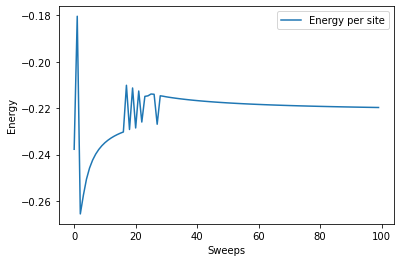

-2.0824284878151467e-05 Difference in last two sweeps
-0.21969253903895028 Final energy
Error 0.9297613002552385 %


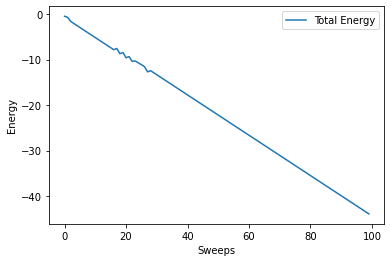

In [44]:
plt.plot(Ener1.real,label="Energy per site")
plt.legend()
plt.ylabel("Energy")
plt.xlabel("Sweeps")
plt.show()
print(Ener1.real[n-1]-Ener1.real[n-2],"Difference in last two sweeps")
print(Ener1.real[n-1],"Final energy")
print("Error {0} %".format((1 - float(Ener1.real[n-1]/(E/L)))*100))

plt.plot(Ener.real,label="Total Energy")
plt.legend()
plt.ylabel("Energy")
plt.xlabel("Sweeps")
plt.show()
